In [31]:
import pathlib, random, os
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from IPython.display import clear_output
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

# Criando e analizando dataset

dataset.classe2idx={'circulo': 0, 'vazio': 1, 'triangulo': 2}
classe=tensor(2)


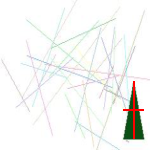

In [26]:
IMG_SIZE = 150

transformer = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(.5, .5, .5), std=(.5, .5, .5))
])

inv_transformer = transforms.Compose([
    transforms.Normalize(mean=(-1., -1., -1.), std=(2., 2., 2.)),
    transforms.ToPILImage()
])

class custom_dataset(Dataset):
    def __init__(self, df_):
        self.df_ = df_
        classes = self.df_['classe'].unique()
        self.classe2idx = {v:k for k, v in enumerate(classes)}
        self.idx2classe = {k:v for k, v in enumerate(classes)}
    
    def __getitem__(self, index):
        # img_path,img_w,img_h,xc/img_w,yc/img_h,w/img_w,h/img_h,classe
        img_path, imgw, imgh, xc, yc, w, h, classe = self.df_.values[index]
        img_pil = Image.open(img_path)
        return transformer(img_pil), torch.tensor([xc, yc, w, h]), torch.tensor(self.classe2idx[classe])

    def __len__(self):
        return len(self.df_)
    
    def desenha_amostra(self):
        img_tensor, bbox, classe = random.choice(self)
        img_pil = inv_transformer(img_tensor)
        draw = ImageDraw.Draw(img_pil)
        xc, yc, w, h = bbox
        xc, yc, w, h = xc*IMG_SIZE, yc*IMG_SIZE, w*IMG_SIZE, h*IMG_SIZE
        draw.line([xc, yc-h/2, xc, yc+h/2], fill='red', width=2)
        draw.line([xc-w/2, yc, xc+w/2, yc], fill='red', width=2)
        return img_pil, classe
        
df = pd.read_csv('annotations.csv')
dataset = custom_dataset(df)
img_tensor, bbox, classe = random.choice(dataset)
img_pil, classe = dataset.desenha_amostra()
print (f'{dataset.classe2idx=}')
print (f'{classe=}')
img_pil

In [27]:
img_tensor, bbox, classe = random.choice(dataset)
print (f'{img_tensor.shape=}, {bbox=}, {classe=}')

img_tensor.shape=torch.Size([3, 150, 150]), bbox=tensor([0.2612, 0.6405, 0.2935, 0.1952]), classe=tensor(2)


# Criando o modelo

In [5]:
class CustomModel(nn.Module):

    def __init__(self, input):
        super(CustomModel, self).__init__()

        self.backbone = nn.Sequential(
            
            nn.Conv2d(in_channels=3, out_channels=256, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(num_features=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(kernel_size=2),

        )

        output_backbone = self.backbone(input)
        _, c, x, y = output_backbone.shape
        in_features = c*x*y

        self.pbox = nn.Sequential(
            self.backbone,
            nn.Flatten(),
            nn.Linear(in_features=in_features, out_features=512, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=4, bias=True),
            nn.ReLU()
        )

        self.pclasse = nn.Sequential(
            self.backbone,
            nn.Flatten(),
            nn.Linear(in_features=in_features, out_features=128, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=3),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        pred_bbox = self.pbox(x)
        pred_classe = self.pclasse(x)
        return pred_bbox, pred_classe

dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
batch_imgs, batch_bbox, batch_target = next(iter(dataloader))

model = CustomModel(batch_imgs)
output = model(batch_imgs)
print (output)

(tensor([[0.0000, 0.1670, 0.2360, 0.1332],
        [0.0482, 0.1540, 0.1514, 0.1473]], grad_fn=<ReluBackward0>), tensor([[0.2969, 0.3973, 0.3058],
        [0.3223, 0.3896, 0.2881]], grad_fn=<SoftmaxBackward>))


# Preparando dados para treinamento

In [28]:
df = pd.read_csv('annotations.csv')
df_train, df_test = train_test_split(df, test_size=.1, shuffle=True, stratify=df['classe'])

train_dataset = custom_dataset(df_train)
test_dataset = custom_dataset(df_test)

print (f'{len(train_dataset)=}, {len(test_dataset)=}')

BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print (f'{len(train_dataloader)=}, {len(test_dataloader)=}')

batch_tensor, batch_bbox, batch_target = next(iter(test_dataloader))
print (f'{batch_tensor.shape=}')

model = CustomModel(batch_tensor) # apenas iniciando o modelo

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print (f'{device=}')

model.to(device)

criterion_bbox = nn.MSELoss()
criterion_target = nn.CrossEntropyLoss()

criterion_bbox.to(device)
criterion_target.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)]

log_dir = './logs/treinamento-1'
docs_list = list(pathlib.Path(log_dir).glob('*'))
for doc_path in docs_list:
    os.remove(str(doc_path))
writer = SummaryWriter(log_dir='./logs/treinamento-1')

len(train_dataset)=13500, len(test_dataset)=1500
len(train_dataloader)=422, len(test_dataloader)=47
batch_tensor.shape=torch.Size([32, 3, 150, 150])
device=device(type='cuda', index=0)


# Funções uteis

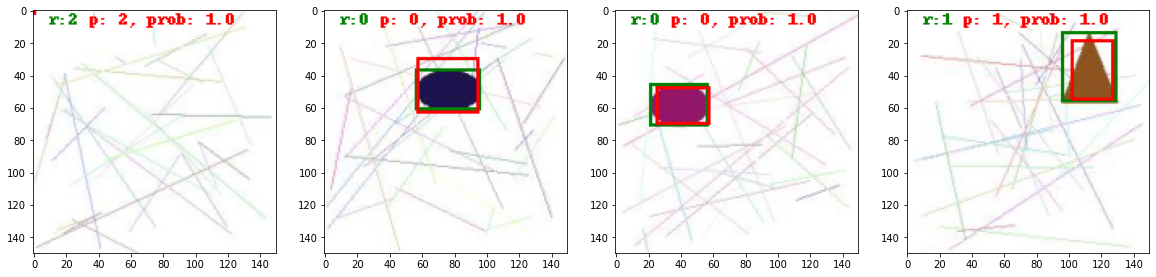

In [44]:
def validar(dataloader_):
    model.eval()
    clear_output(wait=True)
    print ('validação')
    with torch.no_grad():
        bbox_loss, target_loss, n = 0, 0, 0
        y_pred, y_true = [], []
        for batch_tensor, batch_bbox, batch_target in tqdm(dataloader_, ncols=50):
            batch_tensor, batch_bbox, batch_target = batch_tensor.to(device), batch_bbox.to(device), batch_target.to(device)
            pred_bbox, pred_target = model(batch_tensor)
            
            loss_bbox = criterion_bbox(pred_bbox, batch_bbox)
            loss_target = criterion_target(pred_target, batch_target)

            y_pred.append(pred_target.argmax(dim=-1).detach().cpu().numpy())
            y_true.append(batch_target.detach().cpu().numpy())

            n += len(batch_tensor)

            bbox_loss += loss_bbox.item()
            target_loss += loss_target.item()
    
    y_pred = np.hstack(y_pred)
    y_true = np.hstack(y_true)
    accuracy_test = accuracy_score(y_true, y_pred)
    
    return bbox_loss/n, target_loss/n, accuracy_test

def centro_box(vetor, new_size):
    xc, yc, w, h = vetor
    x0 = (xc-w/2)*new_size
    x1 = (xc+w/2)*new_size
    y0 = (yc-h/2)*new_size
    y1 = (yc+h/2)*new_size
    return [x0, y0, x1, y1]

def simple_predict():
    model.eval()
    with torch.no_grad():
        img_tensor, real_bbox, real_target = random.choice(test_dataset)
        img_tensor.unsqueeze_(0)

        pred_bbox, predicts_target = model(img_tensor.to(device))
        pred_target = int(predicts_target.argmax(dim=-1)[0])

        prob_target = round(float(predicts_target[0][pred_target]), 2)

        pred_bbox = pred_bbox[0].detach().cpu().numpy()
        real_bbox = real_bbox.detach().cpu().numpy()

        img_pil = inv_transformer(img_tensor[0])
        draw = ImageDraw.Draw(img_pil)
        
        draw.rectangle(centro_box(real_bbox, IMG_SIZE), fill=None, outline='green', width=2)
        draw.text((10, 0), f'r:{real_target}', fill='green')

        draw.rectangle(centro_box(pred_bbox, IMG_SIZE), fill=None, outline='red', width=2)
        #draw.text((35, 0), f'p:{pred_target}, prob: {prob_target}', fill='red')
        draw.text((35,0), f'p: {pred_target}, prob: {prob_target}', fill='red')
        
        return img_pil

def exibir_avaliacao(r, c):
    plt.figure(figsize=(20, 20))
    for k in range(r*c):
        plt.subplot(r, c, k+1)
        plt.imshow(simple_predict())
    
    plt.show()

exibir_avaliacao(1, 4)

# Treinamento

In [30]:
for epoch in range(10):

    clear_output(wait=True)
    print (f'{epoch=}')
    exibir_avaliacao(1, 4)
    
    model.train()
    bbox_train_loss, target_train_loss, n = 0, 0, 0
    
    for batch_tensor, batch_bbox, batch_target in tqdm(train_dataloader, ncols=50):
        batch_tensor, batch_bbox, batch_target = batch_tensor.to(device), batch_bbox.to(device), batch_target.to(device)

        model.zero_grad()

        pred_bbox, pred_target = model(batch_tensor)
        loss_bbox = criterion_bbox(pred_bbox, batch_bbox)
        loss_target = criterion_target(pred_target, batch_target)

        #loss_bbox.backward()
        #loss_target.backward()
        total_loss = loss_bbox + loss_target
        total_loss.backward()

        optimizer.step()

        bbox_train_loss += loss_bbox.item()
        target_train_loss += loss_target.item()
        n += len(batch_tensor)
    
    bbox_train_loss, target_train_loss = bbox_train_loss/n, target_train_loss/n
    
    bbox_test_loss, target_test_loss, accuracy_test = validar(test_dataloader)

    writer.add_scalar('bbox_train_loss', bbox_train_loss, epoch)
    writer.add_scalar('target_train_loss', target_train_loss, epoch)
    writer.add_scalar('bbox_test_loss', bbox_test_loss, epoch)
    writer.add_scalar('target_test_loss', target_test_loss, epoch)
    writer.add_scalar('accuracy_test', accuracy_test, epoch)

validação


100%|█████████████| 47/47 [00:08<00:00,  5.67it/s]


In [35]:
checkpoint = {
    'state_dict': model.state_dict(),
    'epochs': epoch,
    'datetime': datetime.strftime(datetime.now(), '%d/%m/%Y, %H:%M')
}
torch.save(checkpoint, './checkpoint.pt')

# Analisando imagens novas

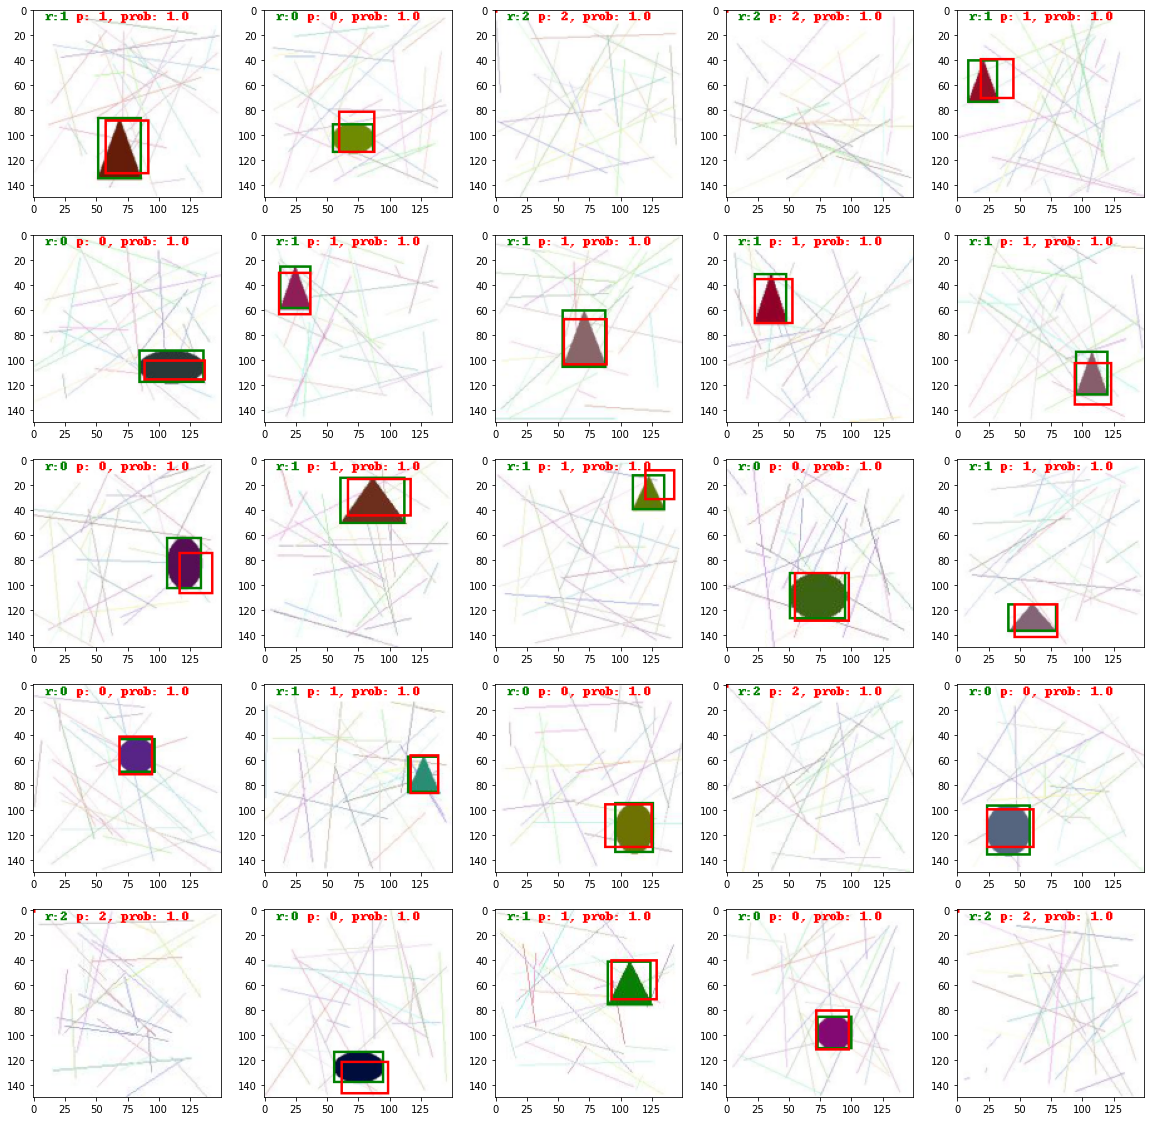

In [47]:
exibir_avaliacao(5, 5)